# 任务2数据清洗
### Task02：数据清洗（2天）

https://github.com/datawhalechina/team-learning/blob/master/数据竞赛（房租预测）/2_数据清洗.ipynb

每一步都要认真完成，附上代码，最终效果截图

<b>缺失值分析及处理</b>

- 缺失值出现的原因分析
- 采取合适的方式对缺失值进行填充

<b>异常值分析及处理</b>

- 根据测试集数据的分布处理训练集的数据分布
- 使用合适的方法找出异常值
- 对异常值进行处理

<b>深度清洗</b>

- 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗

In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost,集成学习的一种方式
import xgboost as xgb
# LightGBM，集成学习的一种方式，据说比xgboost要好
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [2]:
#载入数据
data_train = pd.read_csv('./数据集/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('./数据集/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)
data_all

,ID,Type,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,...,totalWorkers,tradeLandArea,tradeLandNum,tradeMeanPrice,tradeMoney,tradeNewMeanPrice,tradeNewNum,tradeSecNum,tradeTime,uv
0,100309852,Train,68.06,16,1953,36,SH,XQ00051,12,15,...,28248,0.0,0,47974.22551,2000.0,104573.48460,25,111,2018/11/28,284.0
1,100307942,Train,125.55,16,2007,184,SH,XQ00130,27,5,...,14823,0.0,0,40706.66775,2000.0,33807.53497,2,2,2018/12/16,22.0
2,100307764,Train,132.00,37,暂无信息,60,SH,XQ00179,24,35,...,77645,0.0,0,34384.35089,16000.0,109734.16040,11,555,2018/12/22,20.0
3,100306518,Train,57.00,47,暂无信息,364,SH,XQ00313,83,30,...,8750,108037.8,1,20529.55050,1600.0,30587.07058,58,260,2018/12/21,279.0
4,100305262,Train,129.00,10,暂无信息,141,SH,XQ01257,21,5,...,800,0.0,0,24386.36577,2900.0,51127.32846,34,38,2018/11/18,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43904,100314527,Test,66.00,86,2005,461,SH,XQ02427,106,36,...,28546,0.0,0,20299.16352,NaN,31635.24825,34,420,2018/12/31,271.0
43905,100314532,Test,30.00,207,1958,88,SH,XQ01110,35,82,...,855400,0.0,0,53592.38616,NaN,122196.58530,84,549,2018/12/31,35.0
43906,100314560,Test,39.36,207,1980,88,SH,XQ01093,35,82,...,855400,0.0,0,53592.38616,NaN,122196.58530,84,549,2018/12/31,35.0
43907,100314660,Test,57.00,207,1958,88,SH,XQ01108,35,82,...,855400,0.0,0,53592.38616,NaN,122196.58530,84,549,2018/12/23,35.0


In [3]:
data_train

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41435,100000438,10.00,合租,4室1厅1卫,高,11,北,精装,XQ01209,SH,...,4313.0100,20904,0,245872,29635.0,2662.0,0,2018/2/5,2190.0,Train
41436,100000201,7.10,合租,3室1厅1卫,中,6,北,精装,XQ00853,SH,...,0.0000,4370,0,306857,28213.0,2446.0,0,2018/1/22,2090.0,Train
41437,100000198,9.20,合租,4室1厅1卫,高,18,北,精装,XQ00852,SH,...,0.0000,4370,0,306857,19231.0,2016.0,0,2018/2/8,3190.0,Train
41438,100000182,14.10,合租,4室1厅1卫,低,8,北,精装,XQ00791,SH,...,0.0000,4370,0,306857,17471.0,2554.0,0,2018/3/22,2460.0,Train


In [4]:
# 对rentype进行清洗
# data_train['rentType'].value_counts()
# 未知方式    30759
# 整租       5472
# 合租       5204
# --          5
# 这里使用众数的方式填充
data_train['rentType'][data_train['rentType']=="--"] = '未知方式'
# 这里不能翻转顺序
data_train['rentType'].value_counts()

未知方式    30764
整租       5472
合租       5204
Name: rentType, dtype: int64

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 52 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

In [6]:
# 将buildYear列转换为整型数据,求众数插入，我更改成均值
buildYearmean = pd.DataFrame(data_train[data_train['buildYear'] != '暂无信息']['buildYear'].mode())
# print(data_train.loc[data_train[data_train['buildYear'] == '暂无信息'].index, 'buildYear']) #= buildYearmean.iloc[0, 0]
# buildYearmean.iloc[0, 0]
# data['buildYear'] = data['buildYear'].astype('int')
# data_train[data_train['buildYear'] != '暂无信息']['buildYear'].value_counts()
# 这里是不能使用平均数的，因为属性不是int
#buildYearmean = pd.DataFrame(data_train[data_train['buildYear'] != '暂无信息']['buildYear'].mean())
# 这里是平均值
j = 0
j_sum = 0
for i in data_train[data_train['buildYear'] != '暂无信息']['buildYear']:
    j_sum += float(i)
    j+=1
res_j = j_sum//j
data_train['buildYear'][data_train['buildYear']=='暂无信息'] = res_j
data_train['buildYear'].value_counts()

1994      2851
1999.0    2808
2006      2007
2007      1851
2008      1849
          ... 
1939         2
1926         2
1962         1
1951         1
1950         1
Name: buildYear, Length: 80, dtype: int64

In [7]:
#这里有一个自适应函数，是给dataframe的每一列字段，自适应的转类型
data_train = data_train.infer_objects()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 52 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

In [8]:
data_train['pv'].isnull().sum()
# 这里我们使用mean，均值填充
data_train['pv'].fillna(data_train['pv'].mean(),inplace=True)# 均值填充
data_train['pv'].isnull().sum()

0

In [9]:
data_train['uv'].isnull().sum()
# 这里我们使用mean，均值填充
data_train['uv'].fillna(data_train['uv'].mean(),inplace=True)# 均值填充
data_train['uv'].isnull().sum()

0

In [10]:
# 交易时间分割
# 分割交易时间
def month(x):
    month = int(x.split('/')[1])
    return month
def day(x):
    day = int(x.split('/')[2])
    return day
data_train['month'] = data_train['tradeTime'].apply(lambda x: month(x))
data_train['day'] = data_train['tradeTime'].apply(lambda x: day(x))

In [11]:
# 去掉部分特征,这些特征根本没用
data_train.drop('city', axis=1, inplace=True)
data_train.drop('tradeTime', axis=1, inplace=True)
data_train.drop('ID', axis=1, inplace=True)

In [12]:
# 通过孤立森林求均值点
IForest = IsolationForest(contamination=0.01)#孤立点的比例
IForest.fit(data_train["tradeMoney"].values.reshape(-1,1))
# data_train["tradeMoney"].values.reshape(-1,1)
y_pred = IForest.predict(data_train["tradeMoney"].values.reshape(-1,1))
y_pred
#内围点被标记为1，而离群点被标记为-1。 预测方法在估计器计算出的原始评分函数上使用一个阈值。这个评分函数可以通过方法score_samples进行访问，而且这个阈值可以由参数contamination控制。
drop_index = data_train.loc[y_pred==-1].index
print(drop_index)
data_train.drop(drop_index,inplace=True)# 删除离群点
data_train['tradeMoney'].describe()#最小值是0，可以直接去掉

/home/ach/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Int64Index([   62,    69,   128,   131,   146,   246,   261,   266,   297,
              308,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=405)


count    41035.000000
mean      4575.684026
std       2963.764397
min          0.000000
25%       2800.000000
50%       3900.000000
75%       5360.000000
max      22050.000000
Name: tradeMoney, dtype: float64

In [13]:
# 对area进行同样清洗
IForest = IsolationForest(contamination=0.01)#孤立点的比例
IForest.fit(data_train["area"].values.reshape(-1,1))
# data_train["tradeMoney"].values.reshape(-1,1)
y_pred = IForest.predict(data_train["area"].values.reshape(-1,1))
drop_index = data_train.loc[y_pred==-1].index
data_train.drop(drop_index,inplace=True)# 删除离群点
data_train['area'].describe()#最小值是0，可以直接去掉

/home/ach/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


count    40627.000000
mean        66.819522
std         35.825091
min          1.000000
25%         42.100000
50%         64.000000
75%         89.050000
max        199.770000
Name: area, dtype: float64

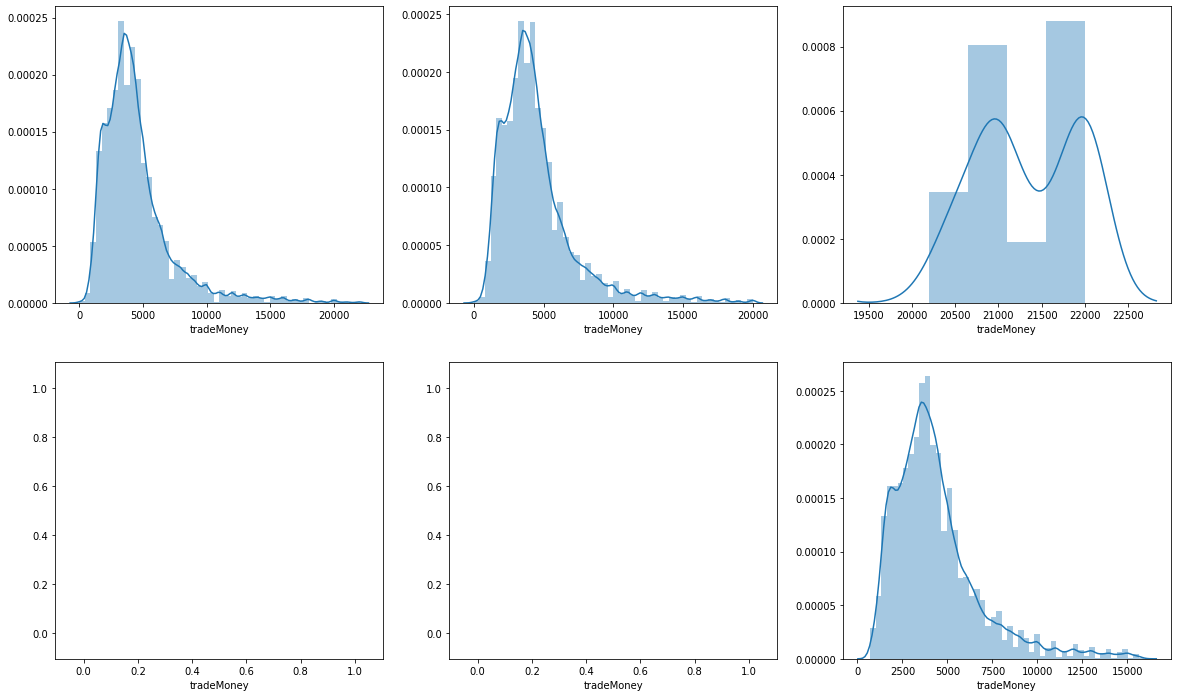

In [14]:
# 目标label值进行分析,sns是一个非常好的分布包
# Labe 分布
fig,axes = plt.subplots(2,3)
fig.set_size_inches(20,12)
sns.distplot(data_train['tradeMoney'],ax=axes[0][0])
sns.distplot(data_train[(data_train['tradeMoney']<=20000)]['tradeMoney'],ax=axes[0][1])
sns.distplot(data_train[(data_train['tradeMoney']>20000)&(data_train['tradeMoney']<=50000)]['tradeMoney'],ax=axes[0][2])
sns.distplot(data_train[(data_train['tradeMoney']>50000)&(data_train['tradeMoney']<=100000)]['tradeMoney'],ax=axes[1][0])
sns.distplot(data_train[(data_train['tradeMoney']>100000)]['tradeMoney'],ax=axes[1][1])
sns.distplot(data_train[(data_train['tradeMoney']>700)&(data_train['tradeMoney']<16000)]['tradeMoney'],ax=axes[1,2])

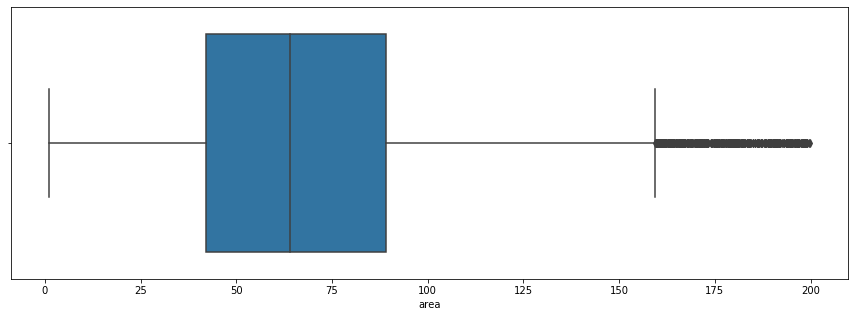

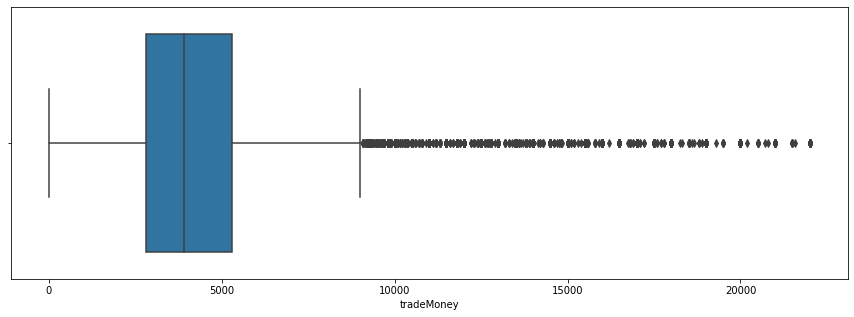

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

In [16]:
# 丢弃部分异常值
data_train = data_train[data_train.area <= 200]#这一步可以不用
data_train = data_train[(data_train.tradeMoney <=16000) & (data_train.tradeMoney >=700)]
# tradeMoney在700-16000里面比较符合于正态分布
# 这里处理特征我保存在后面，要实验一下
data_train.drop(data_train[(data_train['totalFloor'] == 0)].index, inplace=True)
# 这里处理一些异常值

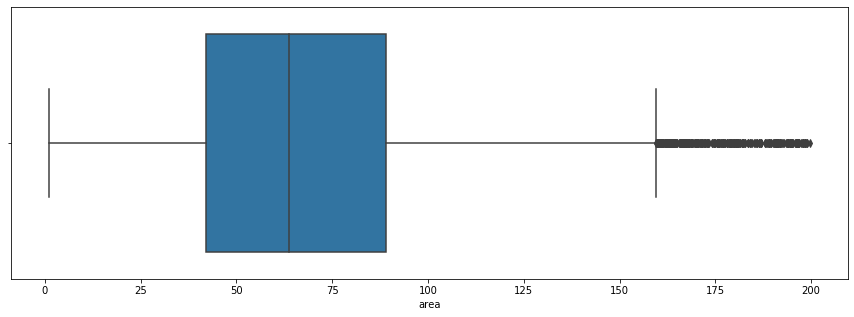

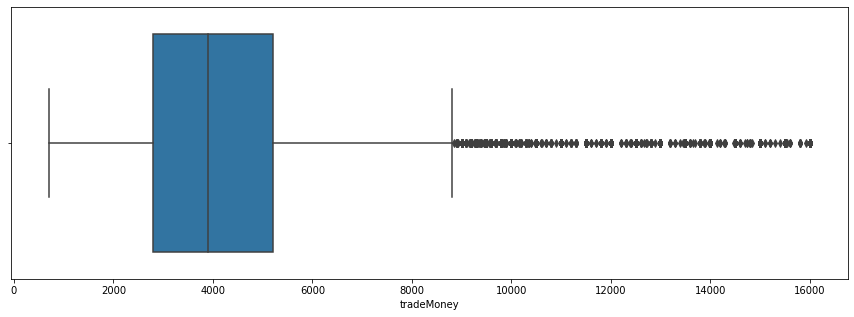

In [17]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

In [18]:
data_train['tradeMoney'].describe()#最小值是0，可以直接去掉

count    40199.000000
mean      4381.931217
std       2498.619096
min        700.000000
25%       2790.000000
50%       3900.000000
75%       5200.000000
max      16000.000000
Name: tradeMoney, dtype: float64

In [19]:
data_train['area'].describe()#最小值是0，可以直接去掉

count    40199.000000
mean        66.109608
std         35.041087
min          1.000000
25%         42.000000
50%         63.620000
75%         89.000000
max        199.620000
Name: area, dtype: float64

communityName
XQ00001     1
XQ00002     2
XQ00003     1
XQ00004     3
XQ00005    13
           ..
XQ04232    13
XQ04233     4
XQ04234     2
XQ04235     3
XQ04236     1
Length: 4012, dtype: int64


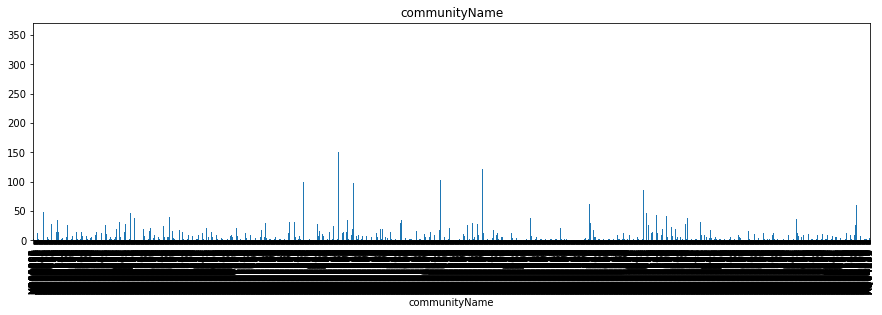

In [20]:
groupby_user = data_train.groupby('communityName').size()
print(groupby_user)
groupby_user.plot.bar(title='communityName',figsize = (15,4))
warnings.filterwarnings("ignore")# 忽略画图的时候的警告

region
RG00001     1134
RG00002    11038
RG00003     4061
RG00004     3297
RG00005     5538
RG00006     1941
RG00007     1591
RG00008     1212
RG00009      649
RG00010     3590
RG00011      689
RG00012     3351
RG00013     1066
RG00014     1041
RG00015        1
dtype: int64


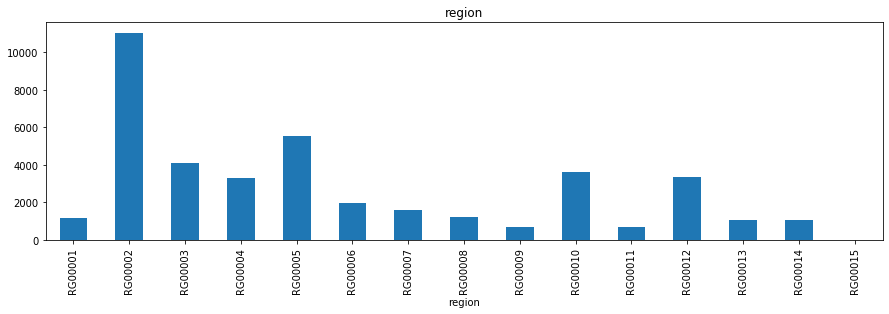

In [21]:
groupby_user = data_train.groupby('region').size()
print(groupby_user)
groupby_user.plot.bar(title='region',figsize = (15,4))
warnings.filterwarnings("ignore")# 忽略画图的时候的警告
# 所以第2区域的房屋很多,对第2区域进行检测area（面积）

In [22]:
def paint_area(fea:str):
    groupby_user = data_train[data_train['region']==fea]['area']
# print(groupby_user)
    groupby_user.plot.bar(title='region={}'.format(fea),figsize = (15,4))
    warnings.filterwarnings("ignore")# 忽略画图的时候的警告
    plt.show()
def paint_trade(fea:str):
    sns.distplot(data_train[data_train['region']==fea]['tradeMoney'])
    data_train[data_train['region']==fea]['tradeMoney'].describe()
    plt.show()

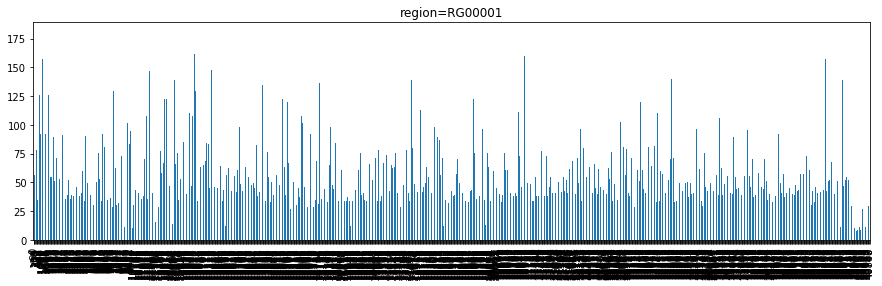

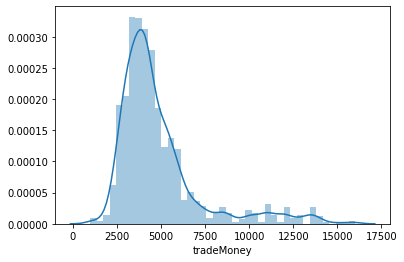

In [27]:
paint_area('RG00001')
paint_trade('RG00001')

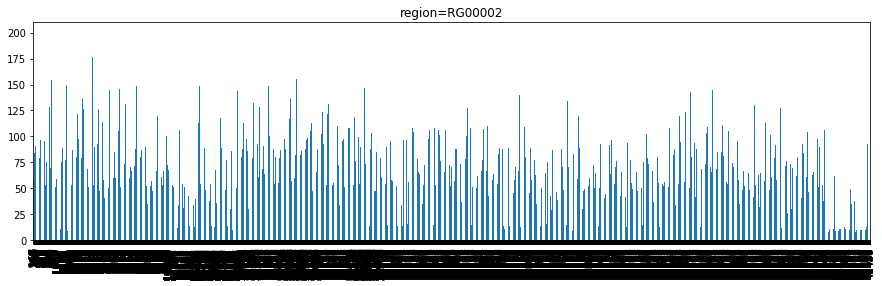

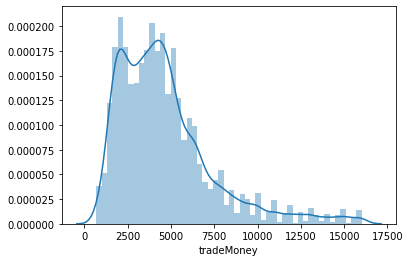

In [29]:
paint_area('RG00002')
paint_trade('RG00002')

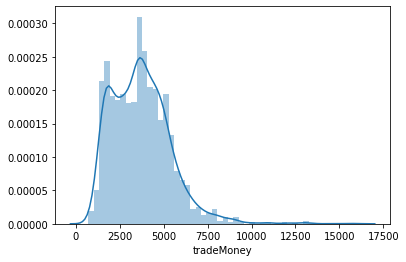

In [23]:
# paint_area('RG00003')
paint_trade('RG00003')

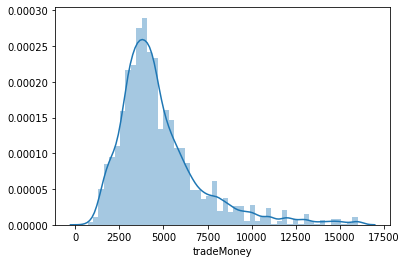

In [24]:
# paint_area('RG00001')
paint_trade('RG00005')

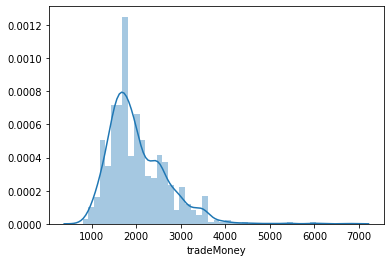

In [25]:
paint_trade('RG00006')

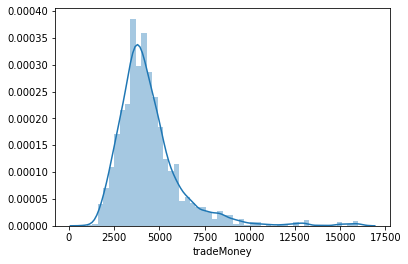

In [26]:
paint_trade('RG00007')

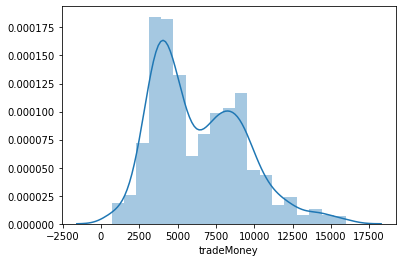

In [27]:
paint_trade('RG00008')

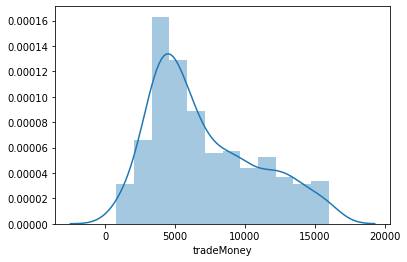

In [28]:
paint_trade('RG00009')

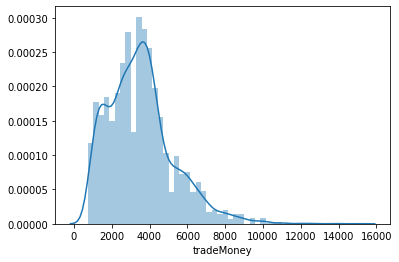

In [29]:
paint_trade('RG00010')

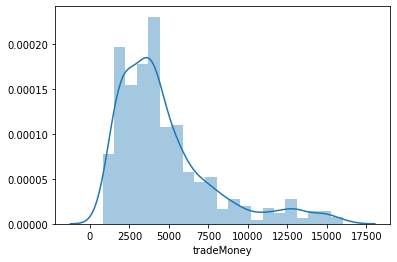

In [30]:
paint_trade('RG00011')

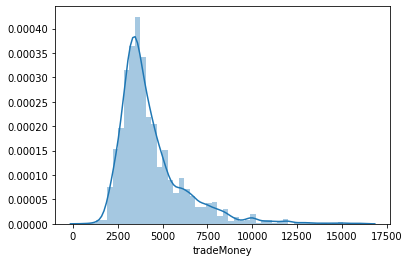

In [31]:
paint_trade('RG00012')

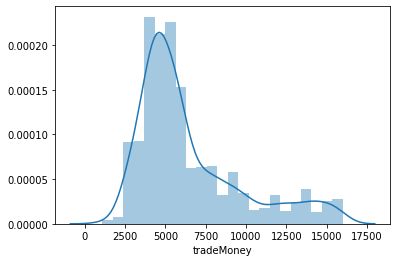

In [32]:
paint_trade('RG00013')

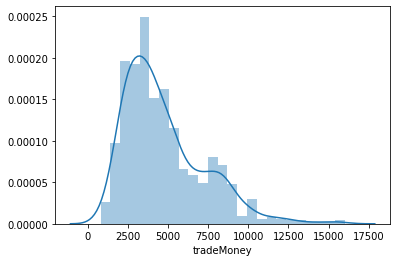

In [33]:
paint_trade('RG00014')

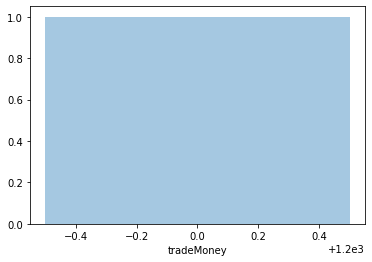

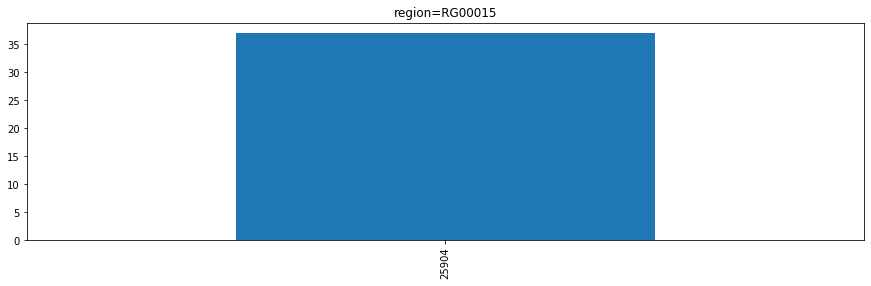

In [34]:
paint_trade('RG00015')
paint_area('RG00015')
#可以删除
#RG00015注意只有这个地方只有一个

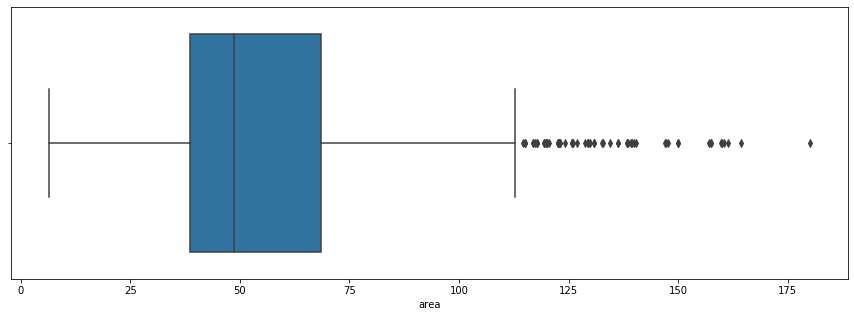

In [35]:
plt.figure(figsize=(15,5))
sns.boxplot(data_train[data_train['region']=='RG00001']['area'])
plt.show()

In [36]:
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,...,28248,614,111546,1124.0,284.0,0,2000.0,Train,11,28
1,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,...,14823,148,157552,701.0,22.0,1,2000.0,Train,12,16
2,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,...,77645,520,131744,57.0,20.0,1,16000.0,Train,12,22
3,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,...,8750,1665,253337,888.0,279.0,9,1600.0,Train,12,21
4,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,...,800,117,125309,2038.0,480.0,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41435,10.00,合租,4室1厅1卫,高,11,北,精装,XQ01209,RG00002,BK00062,...,20904,0,245872,29635.0,2662.0,0,2190.0,Train,2,5
41436,7.10,合租,3室1厅1卫,中,6,北,精装,XQ00853,RG00002,BK00055,...,4370,0,306857,28213.0,2446.0,0,2090.0,Train,1,22
41437,9.20,合租,4室1厅1卫,高,18,北,精装,XQ00852,RG00002,BK00055,...,4370,0,306857,19231.0,2016.0,0,3190.0,Train,2,8
41438,14.10,合租,4室1厅1卫,低,8,北,精装,XQ00791,RG00002,BK00055,...,4370,0,306857,17471.0,2554.0,0,2460.0,Train,3,22


plate
BK00001      1
BK00002    356
BK00003    511
BK00004    174
BK00005    548
          ... 
BK00062    614
BK00063    243
BK00064    570
BK00065    346
BK00066    218
Length: 66, dtype: int64


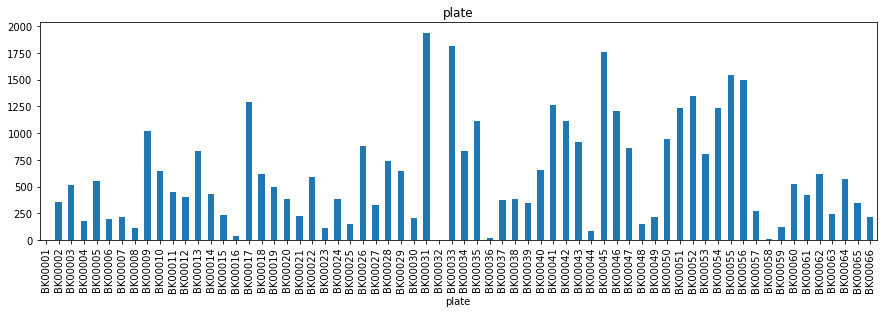

In [37]:
groupby_user = data_train.groupby('plate').size()
print(groupby_user)
groupby_user.plot.bar(title='plate',figsize = (15,4))
warnings.filterwarnings("ignore")# 忽略画图的时候的警告

In [39]:
# groupby_user = data_train.groupby('city').size()
# print(groupby_user)
# groupby_user.plot.bar(title='city',figsize = (15,4))
# warnings.filterwarnings("ignore")# 忽略画图的时候的警告

In [40]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

In [41]:
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,...,28248,614,111546,1124.0,284.0,0,2000.0,Train,11,28
1,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,...,14823,148,157552,701.0,22.0,1,2000.0,Train,12,16
2,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,...,77645,520,131744,57.0,20.0,1,16000.0,Train,12,22
3,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,...,8750,1665,253337,888.0,279.0,9,1600.0,Train,12,21
4,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,...,800,117,125309,2038.0,480.0,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40113,10.00,合租,4室1厅1卫,高,11,北,精装,XQ01209,RG00002,BK00062,...,20904,0,245872,29635.0,2662.0,0,2190.0,Train,2,5
40114,7.10,合租,3室1厅1卫,中,6,北,精装,XQ00853,RG00002,BK00055,...,4370,0,306857,28213.0,2446.0,0,2090.0,Train,1,22
40115,9.20,合租,4室1厅1卫,高,18,北,精装,XQ00852,RG00002,BK00055,...,4370,0,306857,19231.0,2016.0,0,3190.0,Train,2,8
40116,14.10,合租,4室1厅1卫,低,8,北,精装,XQ00791,RG00002,BK00055,...,4370,0,306857,17471.0,2554.0,0,2460.0,Train,3,22


In [42]:
# 使用sklearing中的labelencoder（）函数非数值行转化为数值，通过hash
    # 转换object类型数据
columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
for feature in columns:
        data_train[feature] = LabelEncoder().fit_transform(data_train[feature])
data_train
# labelencoder，这里把所有的非数值型转化为有大小之分的数值型

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,11,1,16,6,0,50,0,62,...,28248,614,111546,1124.0,284.0,0,2000.0,Train,11,28
1,125.55,2,26,0,14,6,2,124,1,47,...,14823,148,157552,701.0,22.0,1,2000.0,Train,12,16
2,132.00,2,26,1,32,6,0,171,1,48,...,77645,520,131744,57.0,20.0,1,16000.0,Train,12,22
3,57.00,2,3,0,17,6,3,300,1,49,...,8750,1665,253337,888.0,279.0,9,1600.0,Train,12,21
4,129.00,2,27,1,2,6,1,1200,2,42,...,800,117,125309,2038.0,480.0,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40113,10.00,0,36,2,11,3,3,1159,1,60,...,20904,0,245872,29635.0,2662.0,0,2190.0,Train,2,5
40114,7.10,0,22,0,6,3,3,822,1,53,...,4370,0,306857,28213.0,2446.0,0,2090.0,Train,1,22
40115,9.20,0,36,2,18,3,3,821,1,53,...,4370,0,306857,19231.0,2016.0,0,3190.0,Train,2,8
40116,14.10,0,36,1,8,3,3,761,1,53,...,4370,0,306857,17471.0,2554.0,0,2460.0,Train,3,22


In [43]:
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,11,1,16,6,0,50,0,62,...,28248,614,111546,1124.0,284.0,0,2000.0,Train,11,28
1,125.55,2,26,0,14,6,2,124,1,47,...,14823,148,157552,701.0,22.0,1,2000.0,Train,12,16
2,132.00,2,26,1,32,6,0,171,1,48,...,77645,520,131744,57.0,20.0,1,16000.0,Train,12,22
3,57.00,2,3,0,17,6,3,300,1,49,...,8750,1665,253337,888.0,279.0,9,1600.0,Train,12,21
4,129.00,2,27,1,2,6,1,1200,2,42,...,800,117,125309,2038.0,480.0,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40113,10.00,0,36,2,11,3,3,1159,1,60,...,20904,0,245872,29635.0,2662.0,0,2190.0,Train,2,5
40114,7.10,0,22,0,6,3,3,822,1,53,...,4370,0,306857,28213.0,2446.0,0,2090.0,Train,1,22
40115,9.20,0,36,2,18,3,3,821,1,53,...,4370,0,306857,19231.0,2016.0,0,3190.0,Train,2,8
40116,14.10,0,36,1,8,3,3,761,1,53,...,4370,0,306857,17471.0,2554.0,0,2460.0,Train,3,22
